# Extracting and Classifying Face Images

https://dev.to/azure/opencv-detect-and-blur-faces-using-dnn-40ab

https://towardsdatascience.com/face-detection-models-which-to-use-and-why-d263e82c302c


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
from sklearn.metrics import classification_report, get_scorer_names
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from mtcnn.mtcnn import MTCNN
from PIL import Image
from sklearn import metrics
import seaborn as sns

# We import the data set from tensorflow and build the model there
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.utils import np_utils
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

import torch
# If you do not have a GPU or do not want to run this code on your GPU, comment out the following lines
torch.cuda.empty_cache()
torch.cuda.is_available()

c:\Users\wamik\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\wamik\miniconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\wamik\miniconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


True

## Extracting the Data

The images stored in the combined dataset are extracted into separate train and test set paths.

NOTE: Before running this file, please unzip the Distacted Driver Dataset that contains the combined dataset.

In [2]:
CLASS = [["c0", "Safe Driving"], ["c1", "Text Right"], ["c2", "Phone Right"], ["c3", "Text Left"], ["c4", "Phone Left"], 
         ["c5", "Adjusting Radio"], ["c6", "Drinking"], 
         ["c7", "Reaching Behind"], ["c8", "Hair or Makeup"], 
         ["c9", "Talking to Passenger"]]
TEST_CLS = [os.path.join(os.getcwd(), "Distracted Driver Dataset", "Camera 1", "test", cls[0]) for cls in CLASS]
TRAIN_CLS = [os.path.join(os.getcwd(), "Distracted Driver Dataset", "Camera 1", "train", cls[0]) for cls in CLASS]
for cls_path in TEST_CLS:
  print(cls_path)
  print(len(os.listdir(cls_path)))
for cls_path in TRAIN_CLS:
  print(cls_path)
  print(len(os.listdir(cls_path)))

c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Camera 1\test\c0
266
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Camera 1\test\c1
133
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Camera 1\test\c2
114
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Camera 1\test\c3
100
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Camera 1\test\c4
90
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Camera 1\test\c5
90
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Camera 1\test\c6
63
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3

For each class, the path of the training and test data is stored in separate lists. The corresponding labels are also stored in a different list

In [3]:
train_paths = []
test_paths = []
for cls in range(10):
  for train_instance in os.listdir(TRAIN_CLS[cls]):
    train_paths.append(os.path.join(TRAIN_CLS[cls], train_instance))
  for test_instance in os.listdir(TEST_CLS[cls]):
    test_paths.append(os.path.join(TEST_CLS[cls], test_instance))

In [4]:
classes = []
test_classes = []
for cls in range(10):
  for train_instance in os.listdir(TRAIN_CLS[cls]):
    classes.append(cls)
  for test_instance in os.listdir(TEST_CLS[cls]):
    test_classes.append(cls)

Then separate dataframes storing the train and test paths with their corresponding labels are created.

In [5]:
df = pd.DataFrame({
  'filename': train_paths,
  'class': classes
})
df

,filename,class
0,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
1,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
2,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
3,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
4,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
...,...,...
10550,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,9
10551,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,9
10552,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,9
10553,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,9


In [6]:
df_test = pd.DataFrame({
  'filename': test_paths,
  'class': test_classes
})
df_test

,filename,class
0,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
1,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
2,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
3,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
4,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
...,...,...
1118,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,9
1119,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,9
1120,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,9
1121,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,9


In [7]:
# -----------------------------------------------
# Face Detection using DNN Net
# -----------------------------------------------
# detect faces using a DNN model 
# download model and prototxt from https://github.com/spmallick/learnopencv/tree/master/FaceDetectionComparison/models

def detectFaceOpenCVDnn(net, frame):
    
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    blob = cv2.dnn.blobFromImage(frame, 1.0, mean = [104, 117, 123])

    net.setInput(blob)
    detections = net.forward()
    conf_threshold = 0.1
    box = None
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            conf_threshold = confidence
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            box = [x1, y1, x2, y2]

    if box == None:
        return []
    # extract the face
    face_boundary = frame[box[1]:box[3], box[0]:box[2]]

    # resize pixels to the model size
    # face_image = Image.fromarray(face_boundary)
    # face_array = np.asarray(face_image)

    return face_boundary

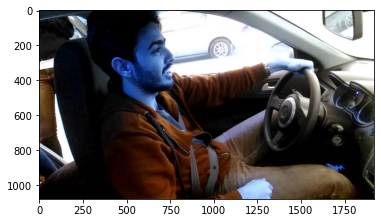

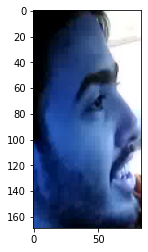

In [8]:
# load face detection model
modelFile = "models/res10_300x300_ssd_iter_140000_fp16.caffemodel"
configFile = "models/deploy.prototxt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

img_orig = cv2.imread(df['filename'].iloc[1000])
plt.imshow(img_orig)
plt.show()
frame = cv2.resize(img_orig, (640, 480))

extracted_face = detectFaceOpenCVDnn(net, frame)
plt.imshow(extracted_face)
plt.show()




In [9]:
X_train_final = []
Y_train = []
for index, path in df.iterrows():
    img_orig = cv2.imread(path[0])
    frame = cv2.resize(img_orig, (640, 480))
    extracted_face = detectFaceOpenCVDnn(net, frame)
    if (index+1) % 135 == 0:
        print("Processed ", index + 1, "images. Continuing...")
    if len(extracted_face) > 0:
        X_train_final.append(np.asarray(extracted_face))
        Y_train.append(path[1])

print("Done!")

Processed  135 images. Continuing...
Processed  270 images. Continuing...
Processed  405 images. Continuing...
Processed  540 images. Continuing...
Processed  675 images. Continuing...
Processed  810 images. Continuing...
Processed  945 images. Continuing...
Processed  1080 images. Continuing...
Processed  1215 images. Continuing...
Processed  1350 images. Continuing...
Processed  1485 images. Continuing...
Processed  1620 images. Continuing...
Processed  1755 images. Continuing...
Processed  1890 images. Continuing...
Processed  2025 images. Continuing...
Processed  2160 images. Continuing...
Processed  2295 images. Continuing...
Processed  2430 images. Continuing...
Processed  2565 images. Continuing...
Processed  2700 images. Continuing...
Processed  2835 images. Continuing...
Processed  2970 images. Continuing...
Processed  3105 images. Continuing...
Processed  3240 images. Continuing...
Processed  3375 images. Continuing...
Processed  3510 images. Continuing...
Processed  3645 ima

In [10]:
print(len(X_train_final))

9875


In [11]:
np.save("Data/extracted faces/train_data_cam1.npy", X_train_final)
np.save("Data/extracted faces/train_labels_cam1.npy", Y_train)

c:\Users\wamik\miniconda3\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [12]:
X_test_final = []
Y_test = []
for index, path in df_test.iterrows():
    img_orig = cv2.imread(path[0])
    frame = cv2.resize(img_orig, (640, 480))
    extracted_face = detectFaceOpenCVDnn(net, frame)
    if (index+1) % 135 == 0:
        print("Processed ", index + 1, "images. Continuing...")
    if len(extracted_face) > 0:
        X_test_final.append(np.asarray(extracted_face))
        Y_test.append(path[1])

print("Done!")

Processed  135 images. Continuing...
Processed  270 images. Continuing...
Processed  405 images. Continuing...
Processed  540 images. Continuing...
Processed  675 images. Continuing...
Processed  810 images. Continuing...
Processed  945 images. Continuing...
Processed  1080 images. Continuing...
Done!


In [13]:
print(len(X_test_final))

1008


In [14]:
np.save("Data/extracted faces/test_data_cam1.npy", X_test_final)
np.save("Data/extracted faces/test_labels_cam1.npy", Y_test)

## Loading Faces Train data

In [15]:
X_train = np.load("Data/extracted faces/train_data_cam1.npy", allow_pickle=True)
Y_train = np.load("Data/extracted faces/train_labels_cam1.npy")

In [16]:
X_test = np.load("Data/extracted faces/test_data_cam1.npy", allow_pickle=True)
Y_test = np.load("Data/extracted faces/test_labels_cam1.npy")

In [17]:
(X_val, X_test_final, Y_val, Y_test_final) = train_test_split(X_test, Y_test, test_size=0.6, stratify=Y_test, random_state=42)
X_val = np.asarray(X_val)
Y_val = np.asarray(Y_val)
X_test_final = np.asarray(X_test_final)
Y_test_final = np.asarray(Y_test_final)
print(X_val.shape)
print(Y_val.shape)

(403,)
(403,)


In [18]:
X_train_resized = []
Y_train_resized = []
i = 0
for x in X_train:
    if len(x)!=0 and len(x[0])!=0:
        img = cv2.resize(x, (75, 100))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # img_blur = cv2.GaussianBlur(img, (3,3), 0)
        # edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)
        # edges = np.asarray(edges)
        # edges = edges.reshape(120, 80, 1)
        X_train_resized.append(img/255.0)
        Y_train_resized.append(Y_train[i])
    i+=1
X_train_resized = np.asarray(X_train_resized)
X_train_resized = X_train_resized.reshape(-1, 100, 75, 1)
X_train_resized.shape

(9846, 100, 75, 1)

Text(0, 0.5, 'Frequency')

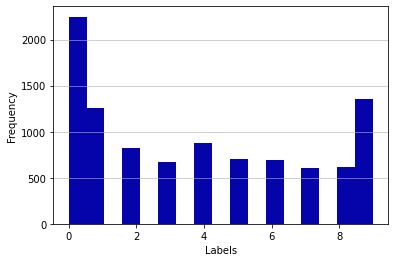

In [19]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=Y_train_resized, bins='auto', color='#0504aa')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Labels')
plt.ylabel('Frequency')

In [20]:
counts = []
for i in range(0, 10):
    counts.append(Y_train_resized.count(i))
np.argmin(counts)

7

In [23]:
df_resized_train = pd.DataFrame({"img": range(9846), "class": Y_train_resized})
df_resized_train

,img,class
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
9841,9841,9
9842,9842,9
9843,9843,9
9844,9844,9


In [ ]:
from sklearn.utils import resample
X_train_sampled = []
Y_train_sampled = []
for c in range(0, 8):
    to_sample = df_resized_train[df_resized_train['class'] == c]
    downsample = resample(to_sample,
             replace=True,
             n_samples=counts[5],
             random_state=42)
    for index, val in downsample['img'].items():
        X_train_sampled.append(X_train_resized[val])
        Y_train_sampled.append(c)
X_train_sampled = np.asarray(X_train_sampled)
X_train_sampled.shape

(6392, 100, 75, 1)

In [27]:
Y_train_sampled = np_utils.to_categorical(Y_train_resized, 10)
print('New y_train shape: ', Y_train_sampled.shape)

New y_train shape:  (9846, 10)


In [24]:
X_val_resized = []
Y_val_resized = []
i = 0
for x in X_val:
    if len(x)!=0 and len(x[0])!=0:
        img = cv2.resize(x, (75, 100))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # img_blur = cv2.GaussianBlur(img, (3,3), 0)
        # edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)
        # edges = np.asarray(edges)
        # edges = edges.reshape(120, 80, 1)
        X_val_resized.append(img/255)
        Y_val_resized.append(Y_train[i])
    i+=1
X_val_resized = np.asarray(X_val_resized)
X_val_resized = X_val_resized.reshape(-1, 100, 75, 1)
X_val_resized.shape

(396, 100, 75, 1)

In [25]:
Y_val_resized = np_utils.to_categorical(Y_val_resized, 10)
print('New y_train shape: ', Y_val_resized.shape)

New y_train shape:  (396, 10)


In [56]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides = (2,2), activation='relu', input_shape=(100, 75, 1)))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(32, (5, 5), strides = (2,2), activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
# model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 48, 36, 32)        832       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 12, 9, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 4, 3, 32)          25632     
                                                                 
 global_average_pooling2d_4   (None, 32)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_7 (Flatten)         (None, 32)                0         
                                                                 
 dropout_7 (Dropout)         (None, 32)               

In [57]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
]

opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 50
EPOCHS = 100

history = model.fit(X_train_resized, Y_train_sampled, epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=callbacks_list,
                    validation_data=(X_val_resized, Y_val_resized), shuffle = True)

Epoch 1/100
197/197 [==============================] - 3s 12ms/step - loss: 2.2098 - accuracy: 0.2330 - val_loss: 1.7203 - val_accuracy: 0.7197
Epoch 2/100
197/197 [==============================] - 2s 10ms/step - loss: 2.1574 - accuracy: 0.2548 - val_loss: 1.6778 - val_accuracy: 0.7929
Epoch 3/100
197/197 [==============================] - 2s 10ms/step - loss: 2.1203 - accuracy: 0.2721 - val_loss: 1.5609 - val_accuracy: 0.7803
Epoch 4/100
197/197 [==============================] - 2s 10ms/step - loss: 2.0784 - accuracy: 0.2936 - val_loss: 1.6128 - val_accuracy: 0.6136
Epoch 5/100
197/197 [==============================] - 2s 10ms/step - loss: 2.0293 - accuracy: 0.3099 - val_loss: 1.8553 - val_accuracy: 0.5051
Epoch 6/100
197/197 [==============================] - 2s 10ms/step - loss: 1.9982 - accuracy: 0.3213 - val_loss: 1.8626 - val_accuracy: 0.5833
Epoch 7/100
197/197 [==============================] - 2s 10ms/step - loss: 1.9695 - accuracy: 0.3337 - val_loss: 1.6994 - val_accuracy:

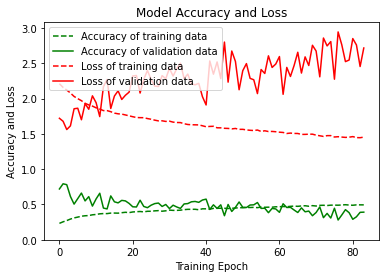

In [58]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [59]:
X_test_resized = []
Y_test_resized = []
i = 0
for x in X_test_final:
    if len(x)!=0 and len(x[0])!=0:
        img = cv2.resize(x, (75, 100))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        X_test_resized.append(img/255)
        Y_test_resized.append(Y_test_final[i])
    i+=1
X_test_resized = np.asarray(X_test_resized)
X_test_resized = X_test_resized.reshape(-1, 100, 75, 1)
X_test_resized.shape

(600, 100, 75, 1)

In [60]:
Y_test_resized = np_utils.to_categorical(Y_test_resized, 10)
print('New y_train shape: ', Y_test_resized.shape)

New y_train shape:  (600, 10)


In [61]:
score = model.evaluate(X_test_resized, Y_test_resized, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

19/19 [==============================] - 0s 9ms/step - loss: 1.7633 - accuracy: 0.3933

Accuracy on test data: 0.39

Loss on test data: 1.76


In [62]:
LABELS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

19/19 [==============================] - 0s 3ms/step


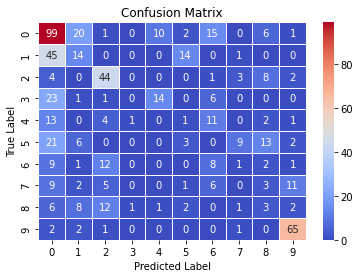


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.43      0.64      0.51       154
           1       0.26      0.19      0.22        74
           2       0.55      0.71      0.62        62
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00        33
           5       0.13      0.06      0.08        54
           6       0.17      0.24      0.20        34
           7       0.00      0.00      0.00        37
           8       0.08      0.08      0.08        36
           9       0.76      0.92      0.83        71

    accuracy                           0.39       600
   macro avg       0.24      0.28      0.25       600
weighted avg       0.32      0.39      0.34       600



In [63]:
y_pred_test = model.predict(X_test_resized)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(Y_test_resized, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

## Preparing Data For Transfer Learning
### Saving Data As Images

In [70]:
X_train = np.load("Data/extracted faces/train_data_cam1.npy", allow_pickle=True)
Y_train = np.load("Data/extracted faces/train_labels_cam1.npy")

In [71]:
for i in range(X_train.shape[0]):
    x = X_train[i]
    if len(x)!=0 and len(x[0])!=0:   
        cv2.imwrite("Data/extracted faces/train_cam1/" + str(Y_train[i]) + "/" + str(i) + ".jpg", x)

In [72]:
X_test = np.load("Data/extracted faces/test_data_cam1.npy", allow_pickle=True)
Y_test = np.load("Data/extracted faces/test_labels_cam1.npy")

In [73]:
for i in range(X_test.shape[0]):
    x_test = X_test[i]
    if len(x_test)!=0 and len(x_test[0])!=0:   
        cv2.imwrite("Data/extracted faces/test_cam1/" + str(Y_test[i]) + "/" + str(i) + ".jpg", x_test)

## Transfer Learning with TensorFlow Keras

https://github.com/tejanirla/image_classification/blob/master/transfer_learning.ipynb

In [74]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir = "Data/extracted faces/train_cam1"
validation_dir = "Data/extracted faces/test_cam1"
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 30,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 40 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 40,
                                                    class_mode = 'categorical', 
                                                    target_size = (100, 75))     

# Flow validation images in batches of 40 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 40,
                                                          class_mode  = 'categorical', 
                                                          target_size = (100, 75))

Found 9846 images belonging to 10 classes.
Found 996 images belonging to 10 classes.


In [77]:
pre_trained_model = InceptionV3(input_shape = (100, 75, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')
for layer in pre_trained_model.layers:
    layer.trainable = True

https://github.com/tejanirla/image_classification/blob/master/transfer_learning.ipynb

In [81]:
last_layer = pre_trained_model.get_layer('mixed4') #Only use layers including and above 'mixed4'
last_op = last_layer.output
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_op)
# # Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (10, activation='softmax')(x)           

model = keras.Model(pre_trained_model.input, x) 

model.compile(optimizer = keras.optimizers.SGD(learning_rate=0.01), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [83]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

In [84]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='acc', patience=2)
]

callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 50,
            epochs = 150,
            validation_steps = 20,
            verbose = 2,
            callbacks=callbacks)

Epoch 1/150
50/50 - 24s - loss: 2.1632 - acc: 0.2660 - val_loss: 1.9046 - val_acc: 0.3862 - 24s/epoch - 479ms/step
Epoch 2/150
50/50 - 15s - loss: 1.9210 - acc: 0.3590 - val_loss: 1.8857 - val_acc: 0.3525 - 15s/epoch - 305ms/step
Epoch 3/150
50/50 - 15s - loss: 1.7954 - acc: 0.3835 - val_loss: 1.7985 - val_acc: 0.4100 - 15s/epoch - 295ms/step
Epoch 4/150
50/50 - 14s - loss: 1.7441 - acc: 0.4080 - val_loss: 1.7412 - val_acc: 0.4000 - 14s/epoch - 280ms/step
Epoch 5/150
50/50 - 13s - loss: 1.6729 - acc: 0.4215 - val_loss: 1.7013 - val_acc: 0.4062 - 13s/epoch - 261ms/step
Epoch 6/150
50/50 - 14s - loss: 1.5709 - acc: 0.4517 - val_loss: 1.7048 - val_acc: 0.3675 - 14s/epoch - 285ms/step
Epoch 7/150
50/50 - 11s - loss: 1.5692 - acc: 0.4550 - val_loss: 1.6955 - val_acc: 0.4087 - 11s/epoch - 220ms/step
Epoch 8/150
50/50 - 11s - loss: 1.5423 - acc: 0.4745 - val_loss: 1.7627 - val_acc: 0.3812 - 11s/epoch - 211ms/step
Epoch 9/150
50/50 - 10s - loss: 1.5127 - acc: 0.4720 - val_loss: 1.6302 - val_ac

KeyboardInterrupt: 

In [85]:
score = model.evaluate(validation_generator, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

25/25 [==============================] - 3s 106ms/step - loss: 2.0756 - acc: 0.4106

Accuracy on test data: 0.41

Loss on test data: 2.08


In [86]:
LABELS = [0, 1, 2, 3, 4, 5, 6, 7]
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

25/25 [==============================] - 2s 52ms/step


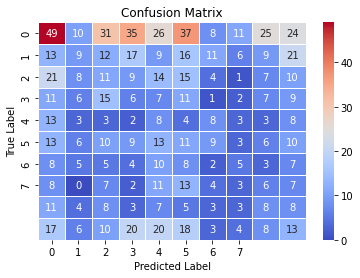


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.30      0.19      0.23       256
           1       0.16      0.07      0.10       123
           2       0.10      0.11      0.10       100
           3       0.06      0.08      0.07        75
           4       0.06      0.15      0.09        55
           5       0.08      0.12      0.10        90
           6       0.04      0.04      0.04        57
           7       0.07      0.05      0.06        61
           8       0.10      0.13      0.11        60
           9       0.11      0.11      0.11       119

    accuracy                           0.12       996
   macro avg       0.11      0.10      0.10       996
weighted avg       0.15      0.12      0.13       996



In [87]:
y_pred_test = model.predict(validation_generator)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = validation_generator.classes

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))